<a href="https://colab.research.google.com/github/bhattacharya5/SpeechUnderstanding/blob/main/MinorProject/M21AIE211_MinorProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd "/content/gdrive/MyDrive/Colab Notebooks/IITJodhpur/Semester5/Speech Analytics/Minor2"

/content/gdrive/MyDrive/Colab Notebooks/IITJodhpur/Semester5/Speech Analytics/Minor2


In [ ]:
pip install mutagen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 4.3 MB/s eta 0:00:00


In [ ]:
import os
import torchaudio
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display
import IPython.display



import time
import zipfile
import mutagen
import mutagen.wave
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image

##Download LIBRISPEECH dataset

In [ ]:
# Specify the directory where you want the dataset to be downloaded
download_dir = 'LIBRISPEECH'
# Check if the dataset directory exists
if not os.path.exists(download_dir):
    # Create the directory if it does not exist
    os.makedirs(download_dir, exist_ok=True)

    # Choose a dataset from torchaudio.datasets, for example, LibriSpeech
    librispeech_dataset = torchaudio.datasets.LIBRISPEECH(root=download_dir, download=True)
else:
    # Load audio samples from LibriSpeech dataset
    librispeech_dataset = torchaudio.datasets.LIBRISPEECH(root=download_dir, download=False)

### Plot waveform

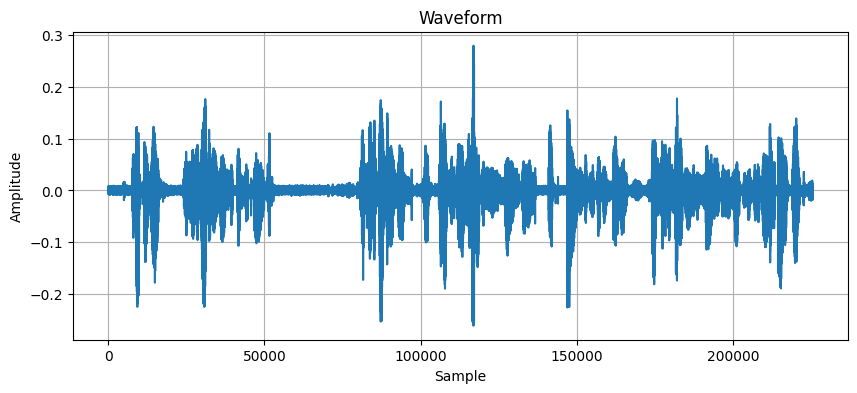

In [ ]:
# Select an index to load a sample from the dataset
index = 0

# Load audio waveform and sample rate for the selected index
waveform, sample_rate, _, _, _, _ = dataset[index]

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(waveform.t().numpy())
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.grid(True)
plt.show()

###Plot spectogram

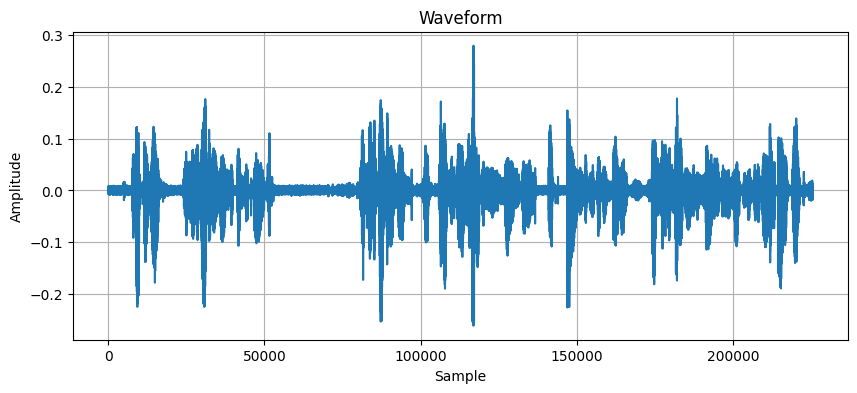

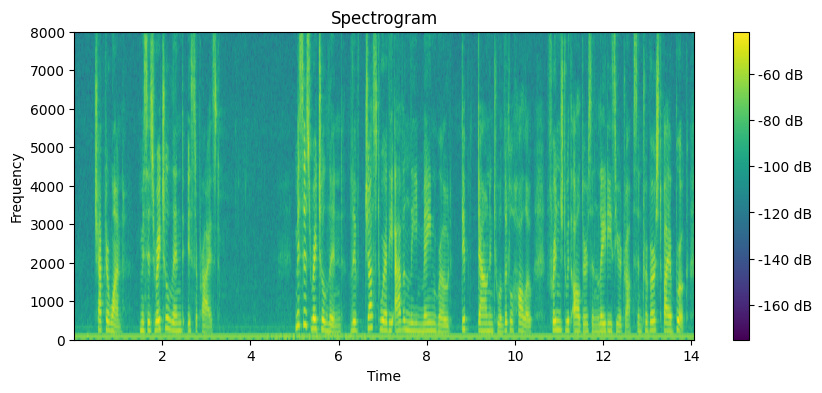

In [ ]:
# Convert waveform to mono if it has more than one channel
if waveform.shape[0] > 1:
    waveform = torch.mean(waveform, dim=0, keepdim=True)

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(waveform.t().numpy())
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.grid(True)
plt.show()

# Compute and plot the spectrogram
plt.figure(figsize=(10, 4))
plt.specgram(waveform.squeeze().numpy(), Fs=sample_rate)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

## Download UrbanSound8K

In [ ]:
ls

 LIBRISPEECH/   M21AIE211_MinorProject.ipynb  'Training autoencoder DB norm.ipynb'


In [ ]:
# Specify the directory where you want the dataset to be downloaded
download_dir = 'UrbanSound8K'
# Check if the dataset directory exists
if not os.path.exists(download_dir):
  # Unzip dataset
  !wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
  !tar -xzf urban8k.tgz
  !rm urban8k.tgz

In [ ]:
ls

 LIBRISPEECH/   M21AIE211_MinorProject.ipynb  'Training autoencoder DB norm.ipynb'   UrbanSound8K/


In [ ]:
!cat UrbanSound8K/UrbanSound8K_README.txt

UrbanSound8K

Created By
----------

Justin Salamon*^, Christopher Jacoby* and Juan Pablo Bello*
* Music and Audio Research Lab (MARL), New York University, USA
^ Center for Urban Science and Progress (CUSP), New York University, USA
http://serv.cusp.nyu.edu/projects/urbansounddataset
http://marl.smusic.nyu.edu/
http://cusp.nyu.edu/

Version 1.0


Description
-----------

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, 
children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, and street_music. The classes are 
drawn from the urban sound taxonomy described in the following article, which also includes a detailed description of 
the dataset and how it was compiled:

J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research", 
22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.

All excerpts are taken from field recordings uploaded to www.freesou

In [ ]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('UrbanSound8K/audio', 'fold'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [ ]:
dataset_df = create_dataset_df('UrbanSound8K/metadata/UrbanSound8K.csv')
dataset_df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,UrbanSound8K/audio/fold5/100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-117.wav
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-121.wav
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-126.wav
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-137.wav


In [ ]:
dataset_df = dataset_df.drop(columns=['fold', 'slice_file_name', 'fsID', 'start', 'end'])

In [ ]:
# Randomly select one sample of each class
random_samples = dataset_df.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

In [ ]:
# Listen to the recordings (index can be changed to listen to a different recording)
index = 0
print('Listen to {} sample'.format(labels[index]))
IPython.display.Audio(audio_samples[index])

Listen to air_conditioner sample


###Plot waveform

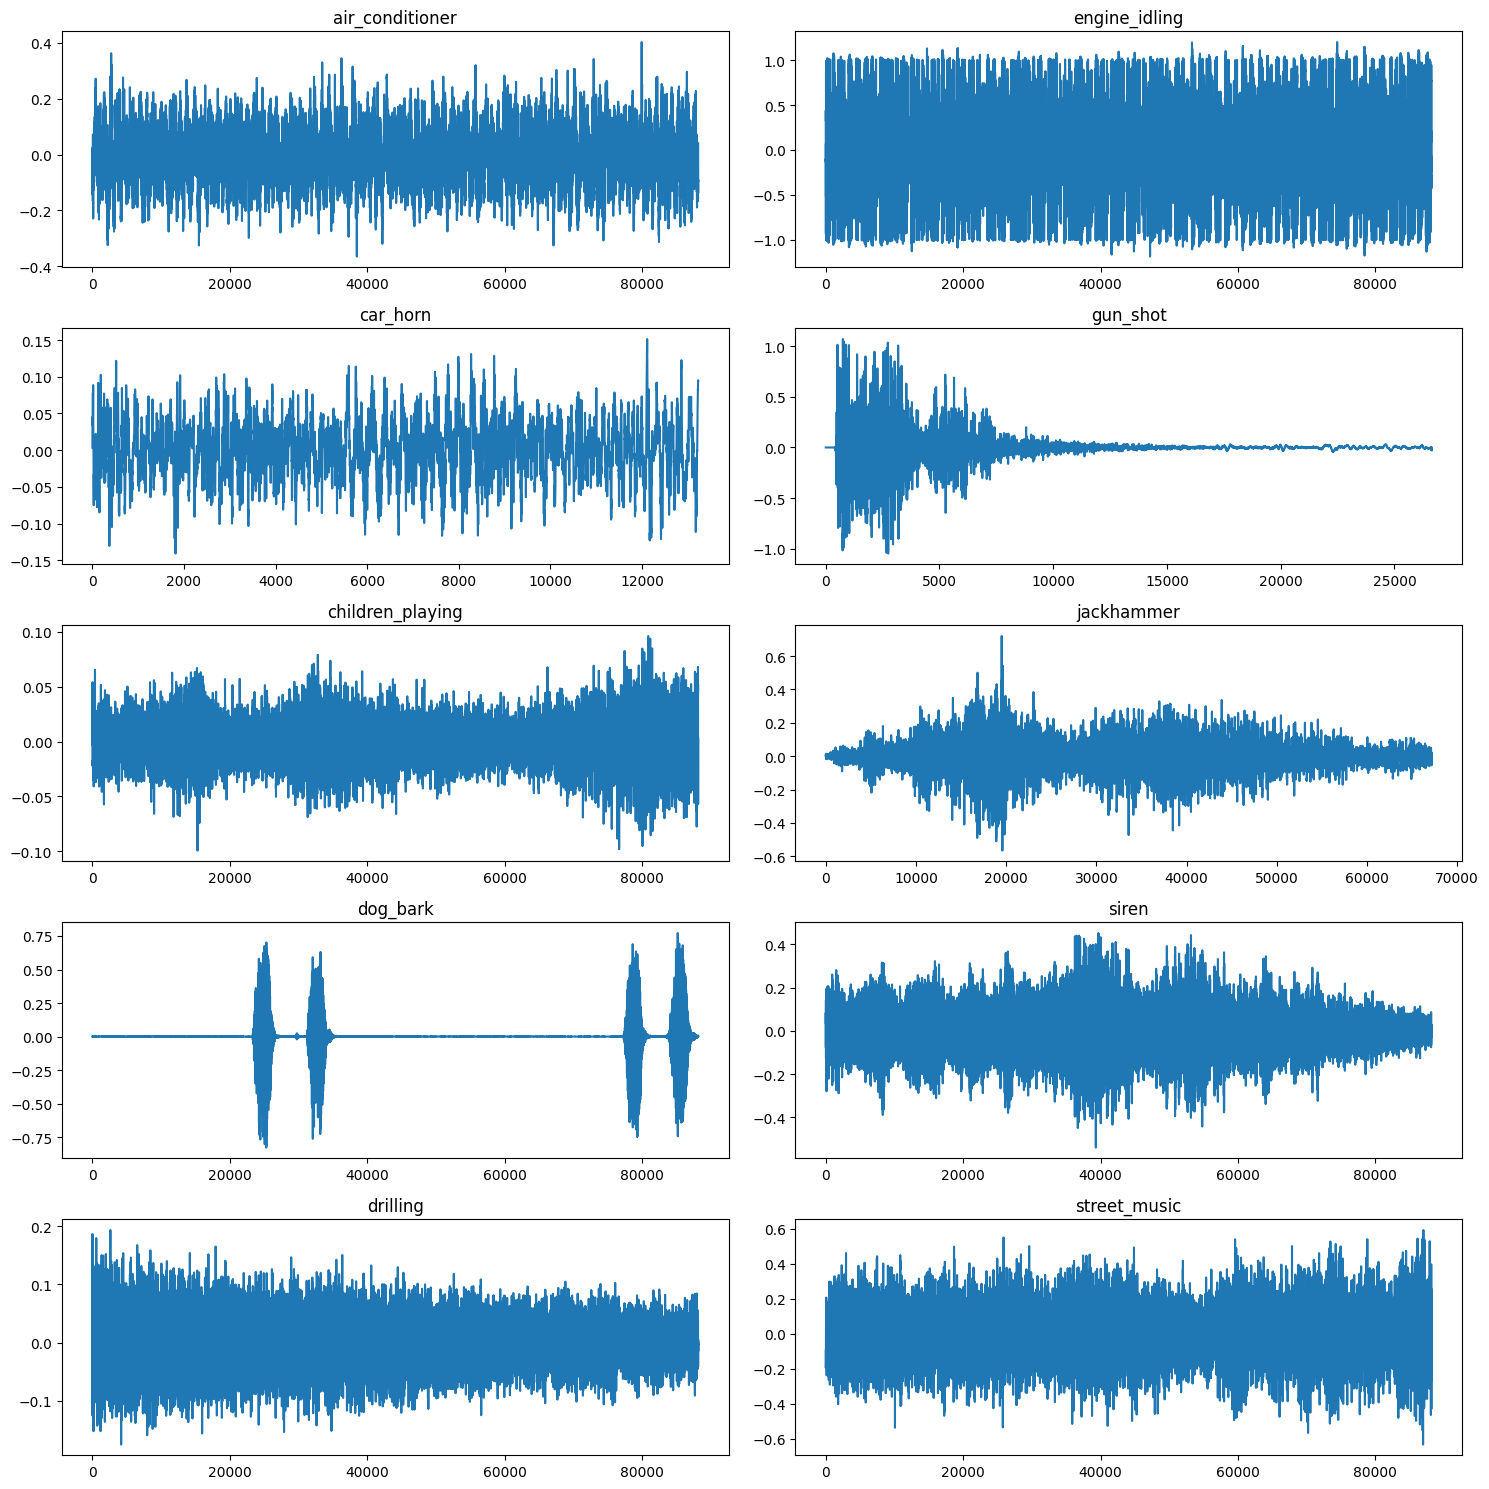

In [ ]:
# Visualize the waveforms
fig, axs = plt.subplots(5, 2, figsize=(15,15))
index = 0
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        axs[row][col].plot(audio_file)
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()


###Plot Spectogram

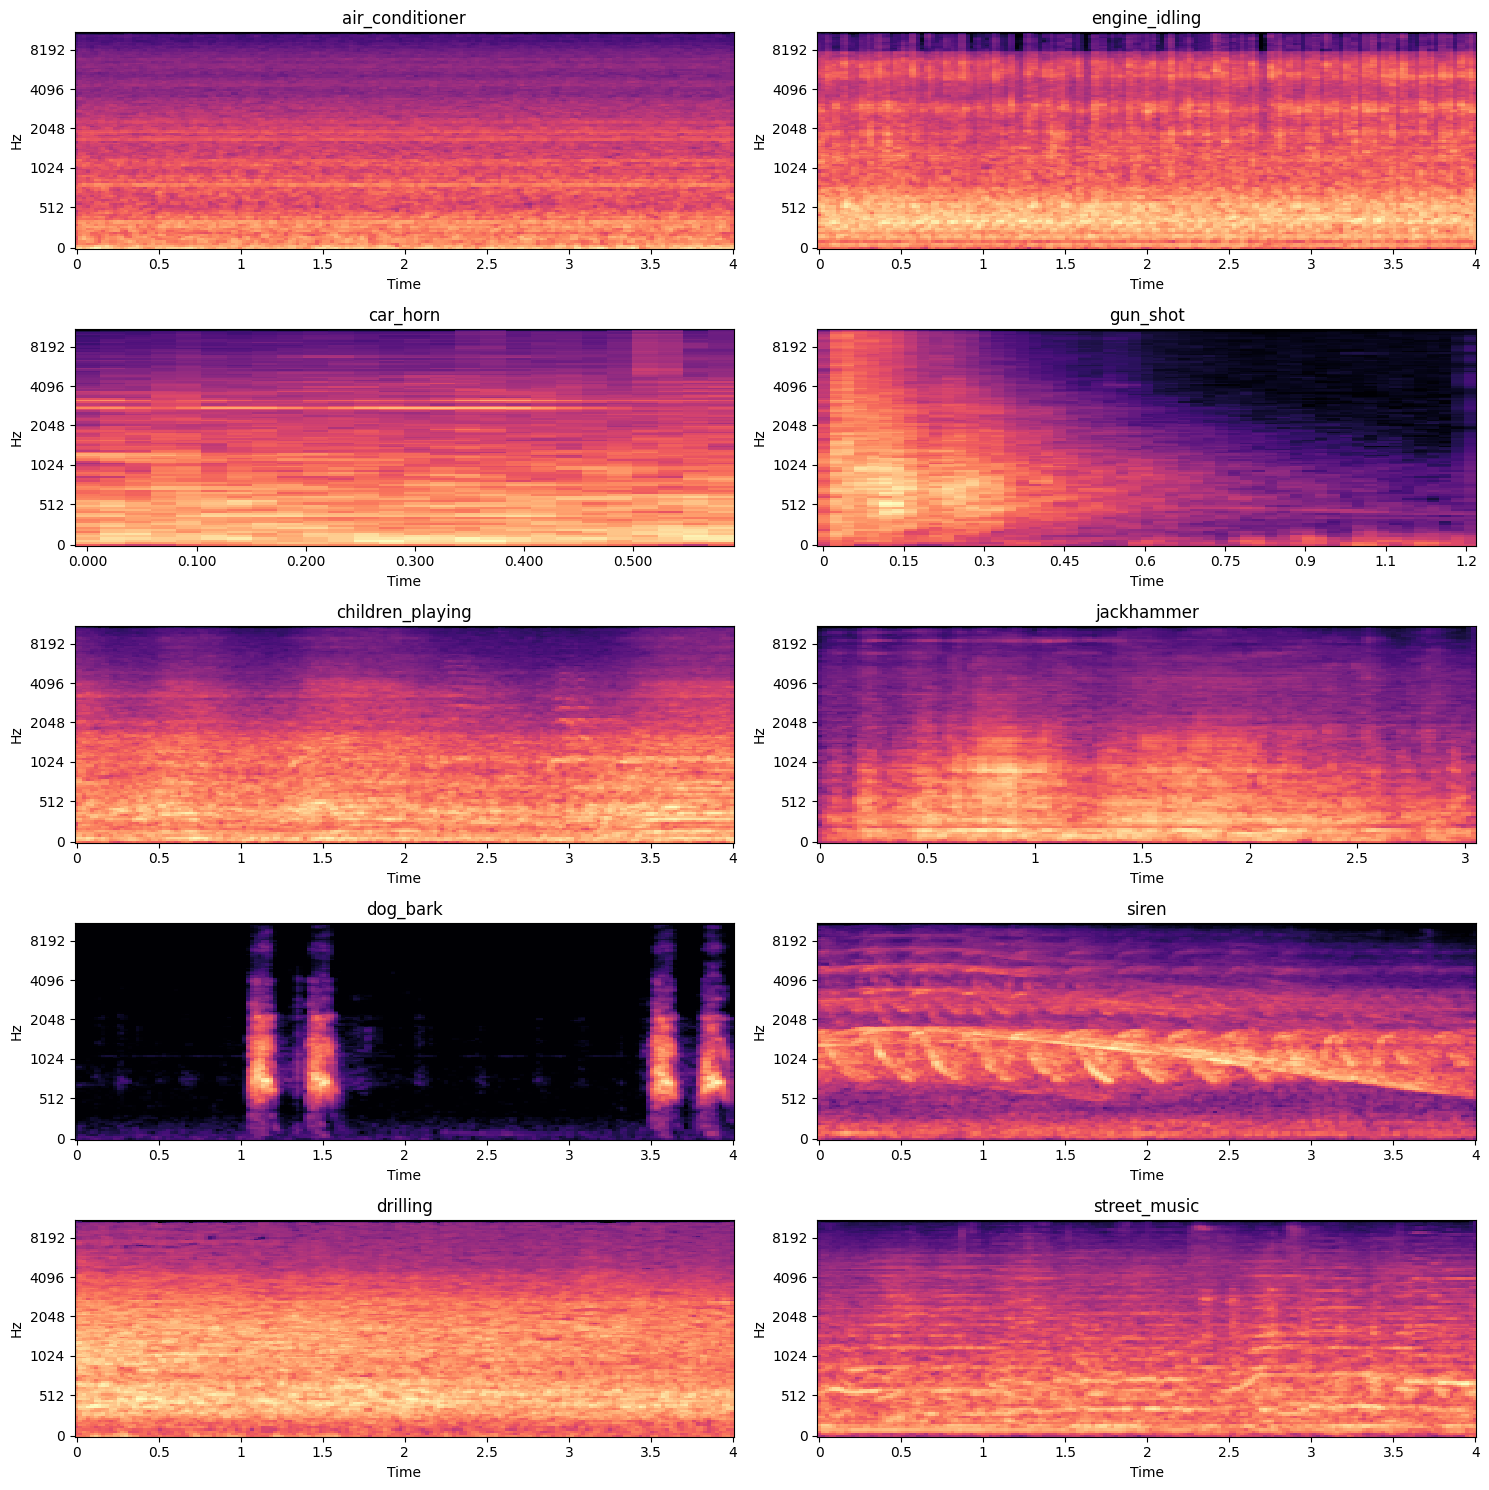

In [ ]:
# Visualize the spectrograms
fig, axs = plt.subplots(5, 2, figsize=(15,15))
index = 0
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        spectrogram = librosa.feature.melspectrogram(y=audio_file, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), sr=sample_rate, ax=axs[row][col], x_axis='time', y_axis='mel')
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()


##Mix combine UrbanSound8K and LIBRISPEECH

In [ ]:
# Combine audio samples from both datasets
mixed_audio_samples = dataset_df + dataset

NameError: name 'dataset' is not defined